# Packages

In [5]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.3f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast
from itertools import combinations


# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
from ambrosia.designer import Designer
from ambrosia.tester import Tester
from expab import get_mde
from expab import get_mde_ratio
from expab import ttest
from expab import ztest_proportion
from expab import ttest_delta
from expab import method_benjamini_hochberg 
from expab import plot_p_value_over_time

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl
from typing import List, Tuple, Union


# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

## Functions

In [ ]:

def method_benjamini_hochberg(
    pvalues: np.ndarray,
    alpha: float = 0.05
    ) -> np.ndarray:
    """Apply the Benjamini-Hochberg procedure for multiple hypothesis testing."""
    m = len(pvalues)
    array_alpha = np.arange(1, m + 1) * alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    return res.astype(int)

# Shapiro-Wilk test & Distributions
def check_normality(df, group_column, value_column):
    groups = df[group_column].unique()

    for group in groups:
        group_data = df[df[group_column] == group][value_column].dropna() 
        stat, p = stats.shapiro(group_data)
        print(f'Group {group}: W={stat:.4f}, p-value={p:.4f}')
        if p > 0.05:
            print(f'Group {group}, Metric: {value_column}: Data is normal distributed')
        else:
            print(f'Group {group}, Metric: {value_column}: Data is not normal distributed')

def plot_distribution(df, group_column, value_column):

    groups = df[group_column].unique()
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1.5]})

    sns.histplot(data=df, x=value_column, hue=group_column, kde=True, bins=30, alpha=0.4, ax=axes[0, 0])
    axes[0, 0].set_title("Graph + KDE")
    axes[0, 0].set_xlabel(value_column)
    axes[0, 0].set_ylabel("Frequence")

    sns.boxplot(data=df, x=group_column, y=value_column, ax=axes[0, 1])
    axes[0, 1].set_title("Boxplot grouped")
    axes[0, 1].set_xlabel(group_column)
    axes[0, 1].set_ylabel(value_column)

    sns.histplot(df[df[group_column] == groups[0]][value_column], bins=30, kde=True, color='blue', alpha=0.5, ax=axes[1, 0])
    axes[1, 0].set_title(f'Hist for the {groups[0]}')
    axes[1, 0].set_xlabel(value_column)
    axes[1, 0].set_ylabel("frequence")

    sns.histplot(df[df[group_column] == groups[1]][value_column], bins=30, kde=True, color='orange', alpha=0.5, ax=axes[1, 1])
    axes[1, 1].set_title(f'Hist for the {groups[1]}')
    axes[1, 1].set_xlabel(value_column)
    axes[1, 1].set_ylabel("Frequence")

    plt.tight_layout()
    plt.show()

# Levene's & Bartlet's test
def levene(df, indicator, metric):
    w_stats, p_value = st.levene(
        df[df['group_name'] == 0][indicator], 
        df[df['group_name'] == 1][indicator],
                            center=metric)
    
    alpha = 0.05
    
    if p_value > alpha:
        print(f"Variance are from the same population on {metric}")
    else:
        print(f"Variance are from the different population on {metric}")
    
# Cohen's D
def cohens_d(df, metric):
    group1 = df[df['group_name']==1][metric]
    group2 = df[df['group_name']==0][metric]
    mean1, mean2 = np.mean(group1), np.mean(group2)
     
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
     
    d = (mean1 - mean2) / pooled_std
     
    # if d <= 0.3:
    #     print(f'Small effect: d ≈ 0-0.3 ({d:.3f})')
    # elif 0.31 <= d <= 0.8:
    #     print(f'Medium effect: d ≈ 0.3-0.8 ({d:.3f})')
    # elif 0.81 <= d <= 1:
    #     print(f'Large effect: d ≈ 0.8-1 ({d:.3f})')

    return d

# SRM
def srm(df):
    srm_df = pd.DataFrame()
        
    observed = [
        (df.query(f'group_name_digit == 0')['user_id'].count()), 
        (df.query(f'group_name_digit == 1')['user_id'].count()),
        (df.query(f'group_name_digit == 2')['user_id'].count()), 
        (df.query(f'group_name_digit == 3')['user_id'].count())
        ]

    total_traffic = sum(observed)

    expected = [total_traffic/4, total_traffic/4, total_traffic/4, total_traffic/4]

    chi = st.chisquare(observed, f_exp = expected)

    if chi[1] < 0.01:
        conclusion = "Sample ratio mismatch (SRM) is observed"
    else:
        conclusion = "Sample ratio mismatch (SRM) isnt observed"
        # print(f"{city}, {chi[1]}")

    
    new_srm_df = pd.DataFrame(
        [[observed, total_traffic, np.round(expected,0), round(chi[1], 3), conclusion]], 
        columns=['sample_sizes', 'total_size', 'expected_sizes', 'chi_value', 'conclusion']
        )

    srm_df = pd.concat([srm_df, new_srm_df]).sort_values(['total_size'], ascending=False).reset_index(drop=True)

    return srm_df

# Calcualting the significance by cities
def calcualate_result(df_cr, df_abs):
    df_results = pd.DataFrame()

    for city in df_cr['city_name'].unique():

        absolute_values_keys_result = df_abs[df_abs['city_name']==f'{city}'].copy()

        cr_df = ztest_proportion(df_cr[df_cr['city_name']==f'{city}'], 'has_ride', 'group_name')
        cr_df['metric'] = 'Conversion'
        cr_df['cohen_d'] = cohens_d(df_cr[df_cr['city_name']==f'{city}'], 'has_ride')

        rides_df = ttest(absolute_values_keys_result, 'rides', 'group_name')
        rides_df['metric'] = 'Quantitive'
        rides_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'rides')

        gmv_df = ttest(absolute_values_keys_result, 'gmv', 'group_name')
        gmv_df['metric'] = 'Quantitive'
        gmv_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'gmv')

        orders_df = ttest(absolute_values_keys_result, 'orders', 'group_name')
        orders_df['metric'] = 'Quantitive'
        orders_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'orders')

        df_total = pd.concat([cr_df, rides_df, gmv_df, orders_df])

        df_total['region'] = city
        df_total['segment'] = 'By city'
        df_total['significance'] = (df_total['pvalue']<0.05)*1
        df_total['corrected_pvalue'] = method_benjamini_hochberg(df_total['pvalue'].values)

        df_results = pd.concat([df_results, df_total])

    total_cr_df = ztest_proportion(df_cr, 'has_ride', 'group_name')
    total_cr_df['metric'] = 'Conversion'
    total_cr_df['cohen_d'] = cohens_d(df_cr, 'has_ride')

    total_rides_df = ttest(df_abs, 'rides', 'group_name')
    total_rides_df['metric'] = 'Quantitive'
    total_rides_df['cohen_d'] = cohens_d(df_abs, 'rides')

    total_gmv_df = ttest(df_abs, 'gmv', 'group_name')
    total_gmv_df['metric'] = 'Quantitive'
    total_gmv_df['cohen_d'] = cohens_d(df_abs, 'gmv')

    total_orders_df = ttest(df_abs, 'orders', 'group_name')
    total_orders_df['metric'] = 'Quantitive'
    total_orders_df['cohen_d'] = cohens_d(df_abs, 'orders')


    total_total_df = pd.concat([total_cr_df, total_rides_df, total_gmv_df, total_orders_df])
    total_total_df['region'] = 'All'
    total_total_df['segment'] = 'Total'
    total_total_df['significance'] = (df_total['pvalue']<0.05)*1
    total_total_df['corrected_pvalue'] = method_benjamini_hochberg(df_total['pvalue'].values)

    df_results = pd.concat([df_results, total_total_df])

    df_results

    return df_results

def calculate_results(df: pd.DataFrame,
                      conversion_metrics=[('first', 'second'), ('third', 'fourth')],
                      usual_metrics=['gmv', 'cnt_orders'],
                      usual_metrics_condition=[('gmv', 'has_order')],
                      ratio_metrics=[('gmv', 'cnt_orders')],
                      ab_group_col='has_treatment',
                      pairs_list=[(0, 1), (0, 2)],
                      alpha=0.05,
                      flag_notation=False):
    
    conversion_metrics_df = pd.DataFrame()
    usual_metrics_df = pd.DataFrame()
    usual_metrics_condition_df = pd.DataFrame()
    ratio_metrics_df = pd.DataFrame()
    
    if conversion_metrics:
        for step1, step2 in conversion_metrics:
            for pair in pairs_list:
                stats = ztest_proportion(
                    df[df[step1] == 1], step2, ab_group_col=ab_group_col, pairs_list=[pair], corrected_ci=1 - alpha, flag_notation=flag_notation
                )
                conversion_metrics_df = pd.concat([conversion_metrics_df, stats])

    if usual_metrics:
        for metric in usual_metrics:
            for pair in pairs_list:
                stats = ttest(
                    df, metric, ab_group_col=ab_group_col, pairs_list=[pair], corrected_ci=1 - alpha, flag_notation=flag_notation
                )
                usual_metrics_df = pd.concat([usual_metrics_df, stats])

    if usual_metrics_condition:
        for metric, condition in usual_metrics_condition:
            for pair in pairs_list:
                stats = ttest(
                    df[df[condition] != 0], metric, ab_group_col=ab_group_col, pairs_list=[pair], corrected_ci=1 - alpha, flag_notation=flag_notation
                )
                usual_metrics_condition_df = pd.concat([usual_metrics_condition_df, stats])

    if ratio_metrics:
        for num_col, denom_col in ratio_metrics:
            for pair in pairs_list:
                stats = ttest_delta(
                    df[df[denom_col] != 0], num_col, denom_col, ab_group_col=ab_group_col, pairs_list=[pair], corrected_ci=1 - alpha, flag_notation=flag_notation
                )
                ratio_metrics_df = pd.concat([ratio_metrics_df, stats])

    results = pd.concat([conversion_metrics_df, usual_metrics_df, usual_metrics_condition_df, ratio_metrics_df])
    return results

# Design of experiment

### Pulling the data

In [ ]:
print('1')
df_to_approve_ride = read_bq("""
   WITH liveness AS (SELECT user_id,
                         os_name,
                         event_dt_part,
                         city_id,
                         country_id,
                         city_name,
                         country_name,
                         fulfilled_flow,
                         MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                LOWER(status) = 'approve',
                                client_time,
                                NULL)) AS status_result
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
                        FROM indriver-e6e40.ods_event_tracker.event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part >= '2025-02-01'
                          AND t2.city_id IN
                              (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 19943, 4261,
                               5573, 4266, 4196, 4376, 4154, 798, 4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199,
                               4524, 4242, 4143, 4155, 4517, 5589, 5548, 4755, 4397, 4226, 4269, 4404, 5600, 4373, 4375,
                               4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264, 4549, 4228, 5291, 4257,
                               4516))
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2025-02-01'
                 AND city_id IN
                     (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 19943, 4261, 5573, 4266,
                      4196, 4376, 4154, 798, 4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143,
                      4155, 4517, 5589, 5548, 4755, 4397, 4226, 4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200,
                      5528, 4234, 4825, 4142, 5536, 4264, 4549, 4228, 5291, 4257, 4516)
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
    SELECT t1.user_id,
        t1.os_name,
        t1.city_id,
        t1.country_id,
        t1.city_name,
        t1.country_name,
        t1.status_result,
        t2.order_timestamp,
        status_order
    FROM liveness t1
            LEFT JOIN rides t2
                    ON t1.user_id = t2.pass_id
                        AND t2.order_timestamp BETWEEN status_result AND DATE_ADD(status_result, INTERVAL + 1 DAY)
    WHERE 1 = 1
    QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY order_timestamp ASC) = 1
""")

print('2')
df_rides_gmv_orders = read_bq("""
    WITH rides AS (SELECT t1.user_id,
                      t1.country_id,
                      t2.country_name,
                      t1.city_id,
                      t2.city_name,
                      AVG(orders_count)  AS orders,
                      AVG(rides_count)   AS rides,
                      SUM(gmv_clean_usd) AS gmv
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                             ON t1.city_id = t2.city_id
               WHERE user_type = 'pass'
                 AND t1.city_id IN (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 19943,
                                    4261, 5573, 4266, 4196, 4376, 4154, 798, 4225, 4198, 4385, 4271, 4374, 4299,
                                    5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589, 5548, 4755, 4397, 4226,
                                    4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142,
                                    5536, 4264, 4549, 4228, 5291, 4257, 4516)
                 AND metric_date_utc >= '2025-03-02'
               GROUP BY t1.user_id, t1.country_id, t2.country_name, t1.city_id, t2.city_name),
     newbies AS (SELECT DISTINCT user_id
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND city_id IN (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 19943,
                                   4261, 5573, 4266, 4196, 4376, 4154, 798, 4225, 4198, 4385, 4271, 4374, 4299,
                                   5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589, 5548, 4755, 4397, 4226,
                                   4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142,
                                   5536, 4264, 4549, 4228, 5291, 4257, 4516)
                   AND metric_date_utc BETWEEN '2024-01-01' AND '2025-03-01')
    SELECT r.*
    FROM rides r
    WHERE r.user_id NOT IN (SELECT user_id FROM newbies);
    """)

print('3')
df_sample_size = read_bq("""
       WITH checker AS (SELECT user_id,
                        os_name,
                        event_dt_part,
                        DATE_TRUNC(event_dt_part, WEEK)  AS weekly,
                        DATE_TRUNC(event_dt_part, MONTH) AS monthly,
                        city_id,
                        country_id,
                        city_name,
                        country_name,
                        fulfilled_flow,
                        MIN(IF(name = 'client.verification_start.click',
                               client_time,
                               NULL))                    AS banner_click,
                        MIN(IF(name = 'client.verification_flow_result_status.show',
                               client_time,
                               NULL))                    AS status_result
                 FROM (SELECT user_id,
                              name,
                              os_name,
                              event_dt_part,
                              TIMESTAMP_MILLIS(client_time)                            AS client_time,
                              t1.city_id,
                              t2.city_name,
                              t2.country_id,
                              t2.country_name,
                              IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                     OVER (PARTITION BY user_id ORDER BY client_time) IS NULL,
                                 JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                 LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                     OVER (PARTITION BY user_id ORDER BY client_time)) AS fulfilled_flow,
                              JSON_EXTRACT_SCALAR(payload, '$.status')                 AS status
                       FROM indriver-e6e40.ods_event_tracker.event t1
                                JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                     ON
                                         t1.city_id = t2.city_id
                       WHERE 1 = 1
                         AND name IN (
                                      'client.verification_flow_result_status.show',
                                      'client.verification_start.click'
                           )
                         AND event_dt_part BETWEEN '2025-02-01' AND '2025-03-30'
                         AND t2.city_id IN
                             (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 19943, 4261,
                              5573, 4266, 4196, 4376, 4154, 798, 4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199,
                              4524, 4242, 4143, 4155, 4517, 5589, 5548, 4755, 4397, 4226, 4269, 4404, 5600, 4373, 4375,
                              4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264, 4549, 4228, 5291, 4257,
                              4516)
                       QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                 GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
       SELECT event_dt_part, weekly, monthly, COUNT(DISTINCT user_id) AS users
       FROM checker
       WHERE status_result IS NULL
       GROUP BY 1, 2, 3
""")


In [ ]:
df_sample_size

### MDE & Period calculating

In [ ]:
daily = int(df_sample_size.groupby(['event_dt_part'], as_index=False)['users'].sum()['users'].mean()*0.25)
weekly = int(df_sample_size.groupby(['weekly'], as_index=False)['users'].sum()['users'].mean()*0.25)
monthly = int(df_sample_size.groupby(['monthly'], as_index=False)['users'].sum()['users'].mean()*0.25)

effects = [1.01, 1.015, 1.05, 1.1]  # MDE in percents
sizes = [daily, weekly, weekly*2, monthly]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.1, 0.2]

df_cr_to_ride_agg = df_to_approve_ride.groupby(['user_id', 'city_name'], as_index=False)['order_timestamp'].count()
df_cr_to_approve = df_to_approve_ride.groupby(['user_id', 'city_name'], as_index=False)['status_result'].count()

design_cr_to_ride = Designer(
        dataframe=df_cr_to_ride_agg, 
        metrics='order_timestamp'
        )

design_cr_to_ride.set_first_errors(first_type_errors)
design_cr_to_ride.set_second_errors(second_type_errors)

df_cr_to_ride_design = design_cr_to_ride.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_cr_to_ride_design['metric'] = 'cr_to_ride'

design_gmv = Designer(
        dataframe=df_rides_gmv_orders, 
        metrics='gmv'
        )

design_gmv.set_first_errors(first_type_errors)
design_gmv.set_second_errors(second_type_errors)

df_gmv_design = design_gmv.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_gmv_design['metric'] = 'gmv'

design_rides = Designer(
        dataframe=df_rides_gmv_orders, 
        metrics='rides'
        )

design_rides.set_first_errors(first_type_errors)
design_rides.set_second_errors(second_type_errors)

df_rides_design = design_rides.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_rides_design['metric'] = 'rides'

design_cr_to_approve = Designer(
        dataframe=df_cr_to_approve, 
        metrics='status_result'
        )

design_cr_to_approve.set_first_errors(first_type_errors)
design_cr_to_approve.set_second_errors(second_type_errors)

df_cr_to_approve_design = design_cr_to_approve.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_cr_to_approve_design['metric'] = 'cr_to_approve'



pd.concat([df_cr_to_ride_design, df_cr_to_approve_design, df_rides_design, df_gmv_design])


# Calculating the results. Summarizing

### Data pulling

In [3]:
df_res = read_bq("""
WITH ab AS (SELECT user_id,
                   t1.city_id,
                   t2.city_name,
                   t2.country_name,
                   group_id,
                   CASE
                       WHEN group_id = 4537434 THEN 'Control'
                       WHEN group_id = 4537435 THEN 'A'
                       WHEN group_id = 4537438 THEN 'B'
                       WHEN group_id = 4537439 THEN 'C'
                       ELSE NULL
                       END group_name,
                   created_dt_part
            FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                     JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                          ON
                              t1.city_id = t2.city_id
            WHERE test_id = 2868
              AND t1.city_id NOT IN (4263, 5568, 4261, 4200, 4267, 5573, 4269, 5600, 4266, 4271, 5589, 4264)),
     newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id IN (25, 54, 46, 12, 23, 24, 43, 75, 77, 10, 11, 22)),
     users AS (SELECT t1.*,
                      t2.metric_date,
                      CASE
                          WHEN t2.user_id IS NULL THEN 1
                          ELSE 0
                          END newbie_flag
               FROM ab t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     checks AS (SELECT user_id,
                       os_name,
                       city_id,
                       filled_flow,
                       MIN(IF(name = 'client.verification_start.show', client_time, NULL))  AS banner_show_dt,
                       MIN(IF(name = 'client.verification_start.click', client_time, NULL)) AS banner_click_dt,
                       MIN(IF((name = 'client.verification_flow_result_status.show' AND LOWER(status) = 'approve'),
                              client_time, NULL))                                           AS approve_dt,
                       MIN(IF((name = 'client.verification_flow_result_status.show' AND LOWER(status) != 'approve'),
                              client_time, NULL))                                           AS not_approve_dt
                FROM (SELECT t1.user_id,
                             t1.name,
                             t1.os_name,
                             DATE(TIMESTAMP_MILLIS(t1.client_time))                         AS event_dt_part,
                             TIMESTAMP_MILLIS(t1.client_time)                               AS client_time,
                             t1.city_id,
                             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')            AS verification_flow,
                             COALESCE(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                          OVER (PARTITION BY user_id ORDER BY client_time),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                          OVER (PARTITION BY user_id ORDER BY client_time)) AS filled_flow,
                             JSON_EXTRACT_SCALAR(payload, '$.status')                       AS status
                      FROM (SELECT *
                            FROM indriver-e6e40.emart.product_event t1
                            WHERE 1 = 1
                              AND name IN (
                                           'client.verification_start.show', 'client.verification_start.click',
                                           'client.verification_flow_result_status.show'
                                )
                              AND event_dt_part BETWEEN '2025-04-03' AND '2025-04-29'
                            QUALIFY
                                ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                                1) t1)
                GROUP BY 1, 2, 3, 4
                QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY approve_dt DESC) =
                        1),
     rides AS (SELECT order_uuid,
                      user_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-04-01'
                   AND '2025-04-30'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driverdone_timestamp IS NOT NULL
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL)),
     gmv AS (SELECT user_id, SUM(gmv_clean_usd) AS gmv, SUM(rides_count) AS rides, SUM(orders_count) AS orders
             FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
             WHERE user_type = 'pass'
               AND metric_date BETWEEN '2025-04-03' AND '2025-04-29'
             GROUP BY 1)
SELECT t1.user_id,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       t1.group_id,
       t1.group_name,
       t1.created_dt_part,
       t1.newbie_flag,
       t2.os_name,
       t2.filled_flow,
       t2.banner_show_dt,
       t2.banner_click_dt,
       COALESCE(t2.approve_dt, t3.order_timestamp) AS approve_dt,
       t2.not_approve_dt,
       t3.order_timestamp,
       COALESCE(t4.gmv, 0)                         AS gmv,
       COALESCE(t4.rides, 0)                       AS rides,
       COALESCE(t4.orders, 0)                      AS orders
FROM users t1
         LEFT JOIN checks t2
                   ON t1.user_id = t2.user_id
         LEFT JOIN rides t3 ON t2.user_id = t3.user_id AND
                               t3.order_timestamp BETWEEN banner_show_dt AND DATE_ADD(banner_show_dt, INTERVAL + 7 DAY)
         LEFT JOIN gmv t4 ON t1.user_id = t4.user_id
WHERE t2.user_id IS NOT NULL
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY order_timestamp) = 1
""")

df_res['filled_flow'] = df_res['filled_flow'].fillna('liveness')
df_res['banner_show_dt'] = df_res['banner_show_dt'].fillna(df_res['approve_dt'])
df_res['banner_click_dt'] = df_res['banner_click_dt'].fillna(df_res['approve_dt'])

df_res.head()

,user_id,city_id,city_name,country_name,group_id,group_name,created_dt_part,newbie_flag,os_name,filled_flow,banner_show_dt,banner_click_dt,approve_dt,not_approve_dt,order_timestamp,gmv,rides,orders
0,17409667,4517,Natal,Brazil,4537435,A,2025-04-05,0,android,liveness,2025-04-05 10:34:11.462000+00:00,2025-04-05 10:34:12.750000+00:00,NaT,NaT,NaT,0.000,0,0
1,38879196,4154,Fortaleza,Brazil,4537439,C,2025-04-07,0,android,documents,2025-04-07 18:22:59.262000+00:00,2025-04-07 18:23:05.366000+00:00,2025-04-07 18:24:08.024000+00:00,NaT,2025-04-07 18:26:24+00:00,7.030,3,12
2,69612363,4517,Natal,Brazil,4537439,C,2025-04-11,0,android,liveness,2025-04-11 15:20:25.344000+00:00,2025-04-11 15:20:28.549000+00:00,NaT,NaT,NaT,0.000,0,0
3,103344904,4517,Natal,Brazil,4537438,B,2025-04-16,1,android,liveness,2025-04-16 19:45:42.350000+00:00,2025-04-16 19:45:43.659000+00:00,2025-04-16 19:46:44.544000+00:00,NaT,2025-04-16 20:26:46+00:00,5.454,1,10
4,124181709,5535,San Pedro Sula,Honduras,4537439,C,2025-04-04,0,android,liveness,2025-04-04 18:23:46.339000+00:00,2025-04-04 18:23:49.502000+00:00,NaT,NaT,NaT,0.000,0,0


In [8]:
df_res['group_name'].unique()

array(['A', 'C', 'B', 'Control'], dtype=object)

In [ ]:
df_push = read_bq("""
WITH ab AS (SELECT user_id,
                   t1.city_id,
                   t2.city_name,
                   t2.country_name,
                   group_id,
                   CASE
                       WHEN group_id = 4537434 THEN 'Control'
                       WHEN group_id = 4537435 THEN 'A'
                       WHEN group_id = 4537438 THEN 'B'
                       WHEN group_id = 4537439 THEN 'C'
                       ELSE NULL
                       END group_name,
                   created_dt_part
            FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                     JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                          ON
                              t1.city_id = t2.city_id
            WHERE test_id = 2868
              AND t1.city_id NOT IN (4263, 5568, 4261, 4200, 4267, 5573, 4269, 5600, 4266, 4271, 5589, 4264)),
     push AS (SELECT user_id,
                     track_id,
                     MIN(IF((event IN ('push_receive', 'es_received')), created_dttm_part, NULL)) AS push_receive,
                     MIN(IF((event IN ('push_open')), created_dttm_part, NULL))                   AS push_open
              FROM indriver-e6e40.ods_smartnotif_cdc.push_stats_global
              WHERE 1 = 1
                AND track_id LIKE 'verification-manager__%_reactivation%'
              GROUP BY 1, 2)
SELECT *
FROM ab t1
         JOIN push t2 ON t1.user_id = t2.user_id
""")

df_push.head()

In [ ]:
df_deeplink = read_bq("""
WITH ab AS (SELECT user_id,
                   t1.city_id,
                   t2.city_name,
                   t2.country_name,
                   group_id,
                   CASE
                       WHEN group_id = 4537434 THEN 'Control'
                       WHEN group_id = 4537435 THEN 'A'
                       WHEN group_id = 4537438 THEN 'B'
                       WHEN group_id = 4537439 THEN 'C'
                       ELSE NULL
                       END group_name,
                   created_dt_part
            FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                     JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                          ON
                              t1.city_id = t2.city_id
            WHERE test_id = 2868
              AND t1.city_id NOT IN (4263, 5568, 4261, 4200, 4267, 5573, 4269, 5600, 4266, 4271, 5589, 4264)),
     newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id IN (25, 54, 46, 12, 23, 24, 43, 75, 77, 10, 11, 22)),
     users AS (SELECT t1.*,
                      t2.metric_date,
                      CASE
                          WHEN t2.user_id IS NULL THEN 1
                          ELSE 0
                          END newbie_flag
               FROM ab t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     checks AS (SELECT user_id,
                       os_name,
                       city_id,
                       filled_flow,
                       filled_entry_point,
                       MIN(IF(name = 'client.verification_start.show', client_time, NULL))  AS banner_show_dt,
                       MIN(IF(name = 'client.verification_start.click', client_time, NULL)) AS banner_click_dt,
                       MIN(IF((name = 'client.verification_flow_result_status.show' AND LOWER(status) = 'approve'),
                              client_time, NULL))                                           AS approve_dt,
                       MIN(IF((name = 'client.verification_flow_result_status.show' AND LOWER(status) != 'approve'),
                              client_time, NULL))                                           AS not_approve_dt
                FROM (SELECT user_id,
                             name,
                             os_name,
                             DATE(TIMESTAMP_MILLIS(client_time))                            AS event_dt_part,
                             TIMESTAMP_MILLIS(client_time)                                  AS client_time,
                             city_id,
                             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')            AS verification_flow,
                             COALESCE(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                          OVER (PARTITION BY user_id ORDER BY client_time),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                          OVER (PARTITION BY user_id ORDER BY client_time)) AS filled_flow,
                             COALESCE(JSON_EXTRACT_SCALAR(payload, '$.entry_point'),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.entry_point'))
                                          OVER (PARTITION BY user_id ORDER BY client_time),
                                      LAG(JSON_EXTRACT_SCALAR(payload, '$.entry_point'))
                                          OVER (PARTITION BY user_id ORDER BY client_time)) AS filled_entry_point,
                             JSON_EXTRACT_SCALAR(payload, '$.status')                       AS status
                      FROM (SELECT *
                            FROM indriver-e6e40.emart.product_event t1
                            WHERE 1 = 1
                              AND name IN (
                                           'client.verification_start.show', 'client.verification_start.click',
                                           'client.verification_flow_result_status.show'
                                )
                              AND event_dt_part BETWEEN '2025-04-03' AND '2025-04-29'
                            QUALIFY
                                ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                                1))
                WHERE filled_entry_point = 'deeplink'
                GROUP BY 1, 2, 3, 4, 5),
     rides AS (SELECT order_uuid,
                      user_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-04-01'
                   AND '2025-04-30'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driverdone_timestamp IS NOT NULL
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL)),
     gmv AS (SELECT user_id, SUM(gmv_clean_usd) AS gmv, SUM(rides_count) AS rides, SUM(orders_count) AS orders
             FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
             WHERE user_type = 'pass'
               AND metric_date BETWEEN '2025-04-03' AND '2025-04-29'
             GROUP BY 1)
SELECT t1.user_id,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       t1.group_id,
       t1.group_name,
       t1.created_dt_part,
       t1.newbie_flag,
       t2.os_name,
       t2.filled_flow,
       t2.filled_entry_point,
       t2.banner_show_dt,
       t2.banner_click_dt,
       COALESCE(t2.approve_dt, t3.order_timestamp) AS approve_dt,
       t2.not_approve_dt,
       t3.order_timestamp,
       COALESCE(t4.gmv, 0)                         AS gmv,
       COALESCE(t4.rides, 0)                       AS rides,
       COALESCE(t4.orders, 0)                      AS orders
FROM users t1
         LEFT JOIN checks t2
                   ON t1.user_id = t2.user_id
         LEFT JOIN rides t3 ON t2.user_id = t3.user_id AND
                               t3.order_timestamp BETWEEN banner_show_dt AND DATE_ADD(banner_show_dt, INTERVAL + 7 DAY)
         LEFT JOIN gmv t4 ON t1.user_id = t4.user_id
WHERE t2.user_id IS NOT NULL
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY order_timestamp) = 1
""")

df_deeplink['filled_flow'] = df_deeplink['filled_flow'].fillna('liveness')
df_deeplink['banner_show_dt'] = df_deeplink['banner_show_dt'].fillna(df_deeplink['approve_dt'])
df_deeplink['banner_click_dt'] = df_deeplink['banner_click_dt'].fillna(df_deeplink['approve_dt'])

df_deeplink.head()

In [12]:
def segment(row):
    if row['group_name'] == 'A':
        return 1
    elif row['group_name'] == 'B':
        return 2
    elif row['group_name'] == 'C':
        return 3
    elif row['group_name'] == 'Control':
        return 0

In [ ]:
df_res['group_name_digit'] = df_res.apply(segment, axis=1)
df_res['approve_flag'] = df_res['approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['not_approve_flag'] = df_res['not_approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['order_flag'] = df_res['order_timestamp'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['banner_show_flag'] = df_res['banner_show_dt'].apply(lambda x: 0 if pd.isna(x) else 1)

df_deeplink['group_name_digit'] = df_deeplink.apply(segment, axis=1)
df_deeplink['approve_flag'] = df_deeplink['approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_deeplink['not_approve_flag'] = df_deeplink['not_approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_deeplink['order_flag'] = df_deeplink['order_timestamp'].apply(lambda x: 0 if pd.isna(x) else 1)
df_deeplink['banner_show_flag'] = df_deeplink['banner_show_dt'].apply(lambda x: 0 if pd.isna(x) else 1)

### Check the key statistics over the tests

#### SRM

In [ ]:
srm(df_res)

In [ ]:
total_srm = pd.DataFrame()

for city in df_res['city_name'].unique():

    city_df = srm(df_res[df_res['city_name']==city])
    city_df['city_name'] = city

    total_srm = pd.concat([total_srm, city_df])


total_srm.sort_values('total_size', ascending=False)

#### Stats by each group

In [ ]:
df_push_agg = df_push.groupby(['country_name', 'group_name'], as_index=False)[['user_id', 'push_receive', 'push_open']].count()
df_push_agg['cr_to_receive'] = df_push_agg['push_receive'] / df_push_agg['user_id']
df_push_agg['open_rate'] = df_push_agg['push_open'] / df_push_agg['push_receive']

df_push_agg

df_push_agg.round(4).pivot_table(index=['country_name'], columns='group_name', values=['cr_to_receive', 'open_rate'], aggfunc='max')

In [ ]:
df_deeplink_agg = df_deeplink.query("os_name in ('android', 'ios') and filled_flow == 'liveness' and group_name_digit != 0").groupby(['group_name', 'newbie_flag', 'os_name'], as_index=False)[['user_id', 'approve_flag', 'not_approve_flag', 'order_flag', 'gmv', 'rides']].agg(
    {
     'user_id':'count',
     'approve_flag':'mean', 
     'not_approve_flag':'mean', 
     'order_flag':'mean', 
     'gmv':'sum', 
     'rides':'sum'
     }
)

# df_deeplink_agg['approve_flag'] = df_deeplink_agg['approve_flag'].astype('str')
# df_deeplink_agg['order_flag'] = df_deeplink_agg['order_flag'].astype('str')

df_deeplink_agg.round(4).pivot_table(index=['newbie_flag', 'os_name'], columns='group_name', values=['approve_flag', 'order_flag', 'rides'], aggfunc='max')

In [ ]:
df_res_agg = df_res.query("os_name in ('android', 'ios') and filled_flow == 'liveness'").groupby(['group_name', 'newbie_flag', 'os_name'], as_index=False)[['user_id', 'approve_flag', 'not_approve_flag', 'order_flag', 'gmv', 'rides']].agg(
    {
     'user_id':'count',
     'approve_flag':'mean', 
     'not_approve_flag':'mean', 
     'order_flag':'mean', 
     'gmv':'sum', 
     'rides':'sum'
     }
)

# df_res_agg['approve_flag'] = df_res_agg['approve_flag'].astype('str')
# df_res_agg['order_flag'] = df_res_agg['order_flag'].astype('str')


df_res_agg.round(4).pivot_table(index=['newbie_flag', 'os_name'], columns='group_name', values=['approve_flag', 'order_flag', 'rides'], aggfunc='max')

### Applying the test for significance calculating

In [ ]:
df_res['rides'] = df_res['rides'].fillna(0)
df_res_cor = df_res[(df_res['gmv']<=np.percentile(df_res['gmv'], 95))&(df_res['newbie_flag']==1)].copy()
df_test = df_res_cor[['user_id', 'created_dt_part', 'os_name', 'newbie_flag', 'group_name_digit', 'group_name', 'banner_show_flag', 'approve_flag', 'not_approve_flag', 'order_flag', 'gmv', 'rides']]
df_test['created_dt_part'] = pd.to_datetime(df_test['created_dt_part'])

In [ ]:
df_res['rides'] = df_res['rides'].fillna(0)
df_res_cor = df_res.query("os_name in ('android', 'ios') and filled_flow == 'liveness'")[
    (df_res['gmv']<=np.percentile(df_res['gmv'], 95))&(df_res['newbie_flag']==0)
    ].copy()
df_test = df_res_cor[['user_id', 'country_name', 'os_name', 'newbie_flag', 'group_name_digit', 'banner_show_flag', 'approve_flag', 'not_approve_flag', 'order_flag', 'gmv', 'rides']]



df_calc = calculate_results(
    df_test,
    conversion_metrics = [('banner_show_flag', 'approve_flag'), 
                            ('banner_show_flag', 'not_approve_flag'),
                            ('banner_show_flag', 'order_flag')],
    usual_metrics=['gmv', 'rides'],
    usual_metrics_condition=[],
    ratio_metrics=[],
    ab_group_col='group_name_digit',
    pairs_list=list(combinations(df_res['group_name_digit'].unique(), 2)),
    alpha=0.05,
    flag_notation=False
    )

df_calc['group0'] = df_calc['group0'].astype(int)
df_calc['group1'] = df_calc['group1'].astype(int)
df_calc['country_name'] = country

df_calc['group0'] = df_calc['group0'].replace({
    0: 'Control',
    1: '5 m',
    2: '10 m',
    3: '6 h'
})

df_calc['group1'] = df_calc['group1'].replace({
    0: 'Control',
    1: '5 m',
    2: '10 m',
    3: '6 h'
})

df_calc['significance'] = (df_calc['pvalue']<0.05)*1
df_calc['result_with_corr'] = method_benjamini_hochberg(pvalues=df_calc['pvalue'].values, alpha=0.05)
df_calc

In [14]:
list(combinations(df_res['group_name_digit'].unique(), 2))

[(1, 3), (1, 2), (1, 0), (3, 2), (3, 0), (2, 0)]

In [ ]:
df_res['group_name_digit'] = df_res.apply(segment, axis=1)
df_res['approve_flag'] = df_res['approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['created_dt_part'] = pd.to_datetime(df_res['created_dt_part'])
df_res['not_approve_flag'] = df_res['not_approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['order_flag'] = df_res['order_timestamp'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res['banner_show_flag'] = df_res['banner_show_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_res[df_res['group_name'].isin(['A', 'C', 'B', 'Control'])]

,user_id,city_id,city_name,country_name,group_id,group_name,created_dt_part,newbie_flag,os_name,filled_flow,banner_show_dt,banner_click_dt,approve_dt,not_approve_dt,order_timestamp,gmv,rides,orders,group_name_digit,banner_show_flag,approve_flag,not_approve_flag,order_flag
0,17409667,4517,Natal,Brazil,4537435,A,2025-04-05,0,android,liveness,2025-04-05 10:34:11.462000+00:00,2025-04-05 10:34:12.750000+00:00,NaT,NaT,NaT,0.000,0,0,1,1,0,0,0
1,38879196,4154,Fortaleza,Brazil,4537439,C,2025-04-07,0,android,documents,2025-04-07 18:22:59.262000+00:00,2025-04-07 18:23:05.366000+00:00,2025-04-07 18:24:08.024000+00:00,NaT,2025-04-07 18:26:24+00:00,7.030,3,12,3,1,1,0,1
2,69612363,4517,Natal,Brazil,4537439,C,2025-04-11,0,android,liveness,2025-04-11 15:20:25.344000+00:00,2025-04-11 15:20:28.549000+00:00,NaT,NaT,NaT,0.000,0,0,3,1,0,0,0
3,103344904,4517,Natal,Brazil,4537438,B,2025-04-16,1,android,liveness,2025-04-16 19:45:42.350000+00:00,2025-04-16 19:45:43.659000+00:00,2025-04-16 19:46:44.544000+00:00,NaT,2025-04-16 20:26:46+00:00,5.454,1,10,2,1,1,0,1
4,124181709,5535,San Pedro Sula,Honduras,4537439,C,2025-04-04,0,android,liveness,2025-04-04 18:23:46.339000+00:00,2025-04-04 18:23:49.502000+00:00,NaT,NaT,NaT,0.000,0,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090582,289917839,4516,Villavicencio,Colombia,4537434,Control,2025-04-10,1,ios,liveness,2025-04-10 20:21:31.943000+00:00,2025-04-10 20:21:34.074000+00:00,2025-04-10 20:22:03.243000+00:00,NaT,NaT,2.823,1,6,0,1,1,0,0
1090583,289925611,4516,Villavicencio,Colombia,4537439,C,2025-04-10,1,android,liveness,2025-04-10 21:50:50.415000+00:00,2025-04-10 21:50:52.393000+00:00,2025-04-10 21:51:41.531000+00:00,NaT,2025-04-10 21:51:46+00:00,9.426,3,4,3,1,1,0,1
1090584,289930188,4516,Villavicencio,Colombia,4537438,B,2025-04-10,1,ios,liveness,2025-04-10 22:45:39.471000+00:00,2025-04-10 22:45:41.354000+00:00,2025-04-10 22:46:15.340000+00:00,NaT,NaT,0.000,0,4,2,1,1,0,0
1090585,291353949,4516,Villavicencio,Colombia,4537438,B,2025-04-19,1,ios,liveness,2025-04-19 14:52:17.019000+00:00,2025-04-19 14:52:18.983000+00:00,2025-04-19 14:53:00.768000+00:00,NaT,2025-04-19 14:53:06+00:00,6.684,4,5,2,1,1,0,1


In [76]:
def segment(row):
    if row['group_name'] == 'B':
        return 1
    else:
        return 0

df_control = df_res[df_res['group_name'].isin(['B', 'Control'])][['group_name', 'created_dt_part', 'group_name_digit', 'banner_show_flag', 'approve_flag']]
df_5m = df_res[df_res['group_name'].isin(['A', 'B'])][['group_name', 'created_dt_part', 'group_name_digit', 'banner_show_flag', 'approve_flag']]
df_6h = df_res[df_res['group_name'].isin(['C', 'B'])][['group_name', 'created_dt_part', 'group_name_digit', 'banner_show_flag', 'approve_flag']]

df_control['group_name_digit'] = df_control.apply(segment, axis=1)
df_5m['group_name_digit'] = df_5m.apply(segment, axis=1)
df_6h['group_name_digit'] = df_6h.apply(segment, axis=1)


def cumulative_ztest_vs_B(df: pd.DataFrame, group_col='group_name', date_col='created_dt_part', metric_col='approve_flag'):
    # Приводим дату к datetime
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # Уникальные даты и группы
    unique_dates = df[date_col].sort_values().unique()
    groups = df[group_col].unique()

    # Группа сравнения — B
    target_group = 'B'
    comparison_groups = [g for g in groups if g != target_group]

    all_results = []

    for comp_group in comparison_groups:
        group_results = []
        for current_date in unique_dates:
            df_cum = df[df[date_col] <= current_date]

            stats = df_cum.groupby(group_col)[metric_col].agg(['sum', 'count'])

            if target_group not in stats.index or comp_group not in stats.index:
                continue

            conv_b = stats.loc[target_group, 'sum']
            total_b = stats.loc[target_group, 'count']
            conv_cmp = stats.loc[comp_group, 'sum']
            total_cmp = stats.loc[comp_group, 'count']

            p1 = conv_b / total_b
            p2 = conv_cmp / total_cmp
            p_pool = (conv_b + conv_cmp) / (total_b + total_cmp)

            numerator = p1 - p2
            denominator = np.sqrt(p_pool * (1 - p_pool) * (1/total_b + 1/total_cmp))
            z = numerator / denominator if denominator != 0 else 0
            p_value = 2 * (1 - norm.cdf(abs(z)))

            group_results.append({
                'date': current_date,
                'p_value': p_value,
                'z_score': z,
                'group_vs': f'{target_group} vs {comp_group}',
                'p1': p1,
                'p2': p2
            })

        all_results.extend(group_results)

    # Общий DataFrame
    results_df = pd.DataFrame(all_results)

    # Построим график
    plt.figure(figsize=(12, 6))
    for key, group_data in results_df.groupby('group_vs'):
        plt.plot(group_data['date'], group_data['p_value'], marker='o', label=key)

    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')
    plt.title(f'Cumulative P-Value Over Time (Z-test vs {target_group})')
    plt.xlabel('Date')
    plt.ylabel('P-Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

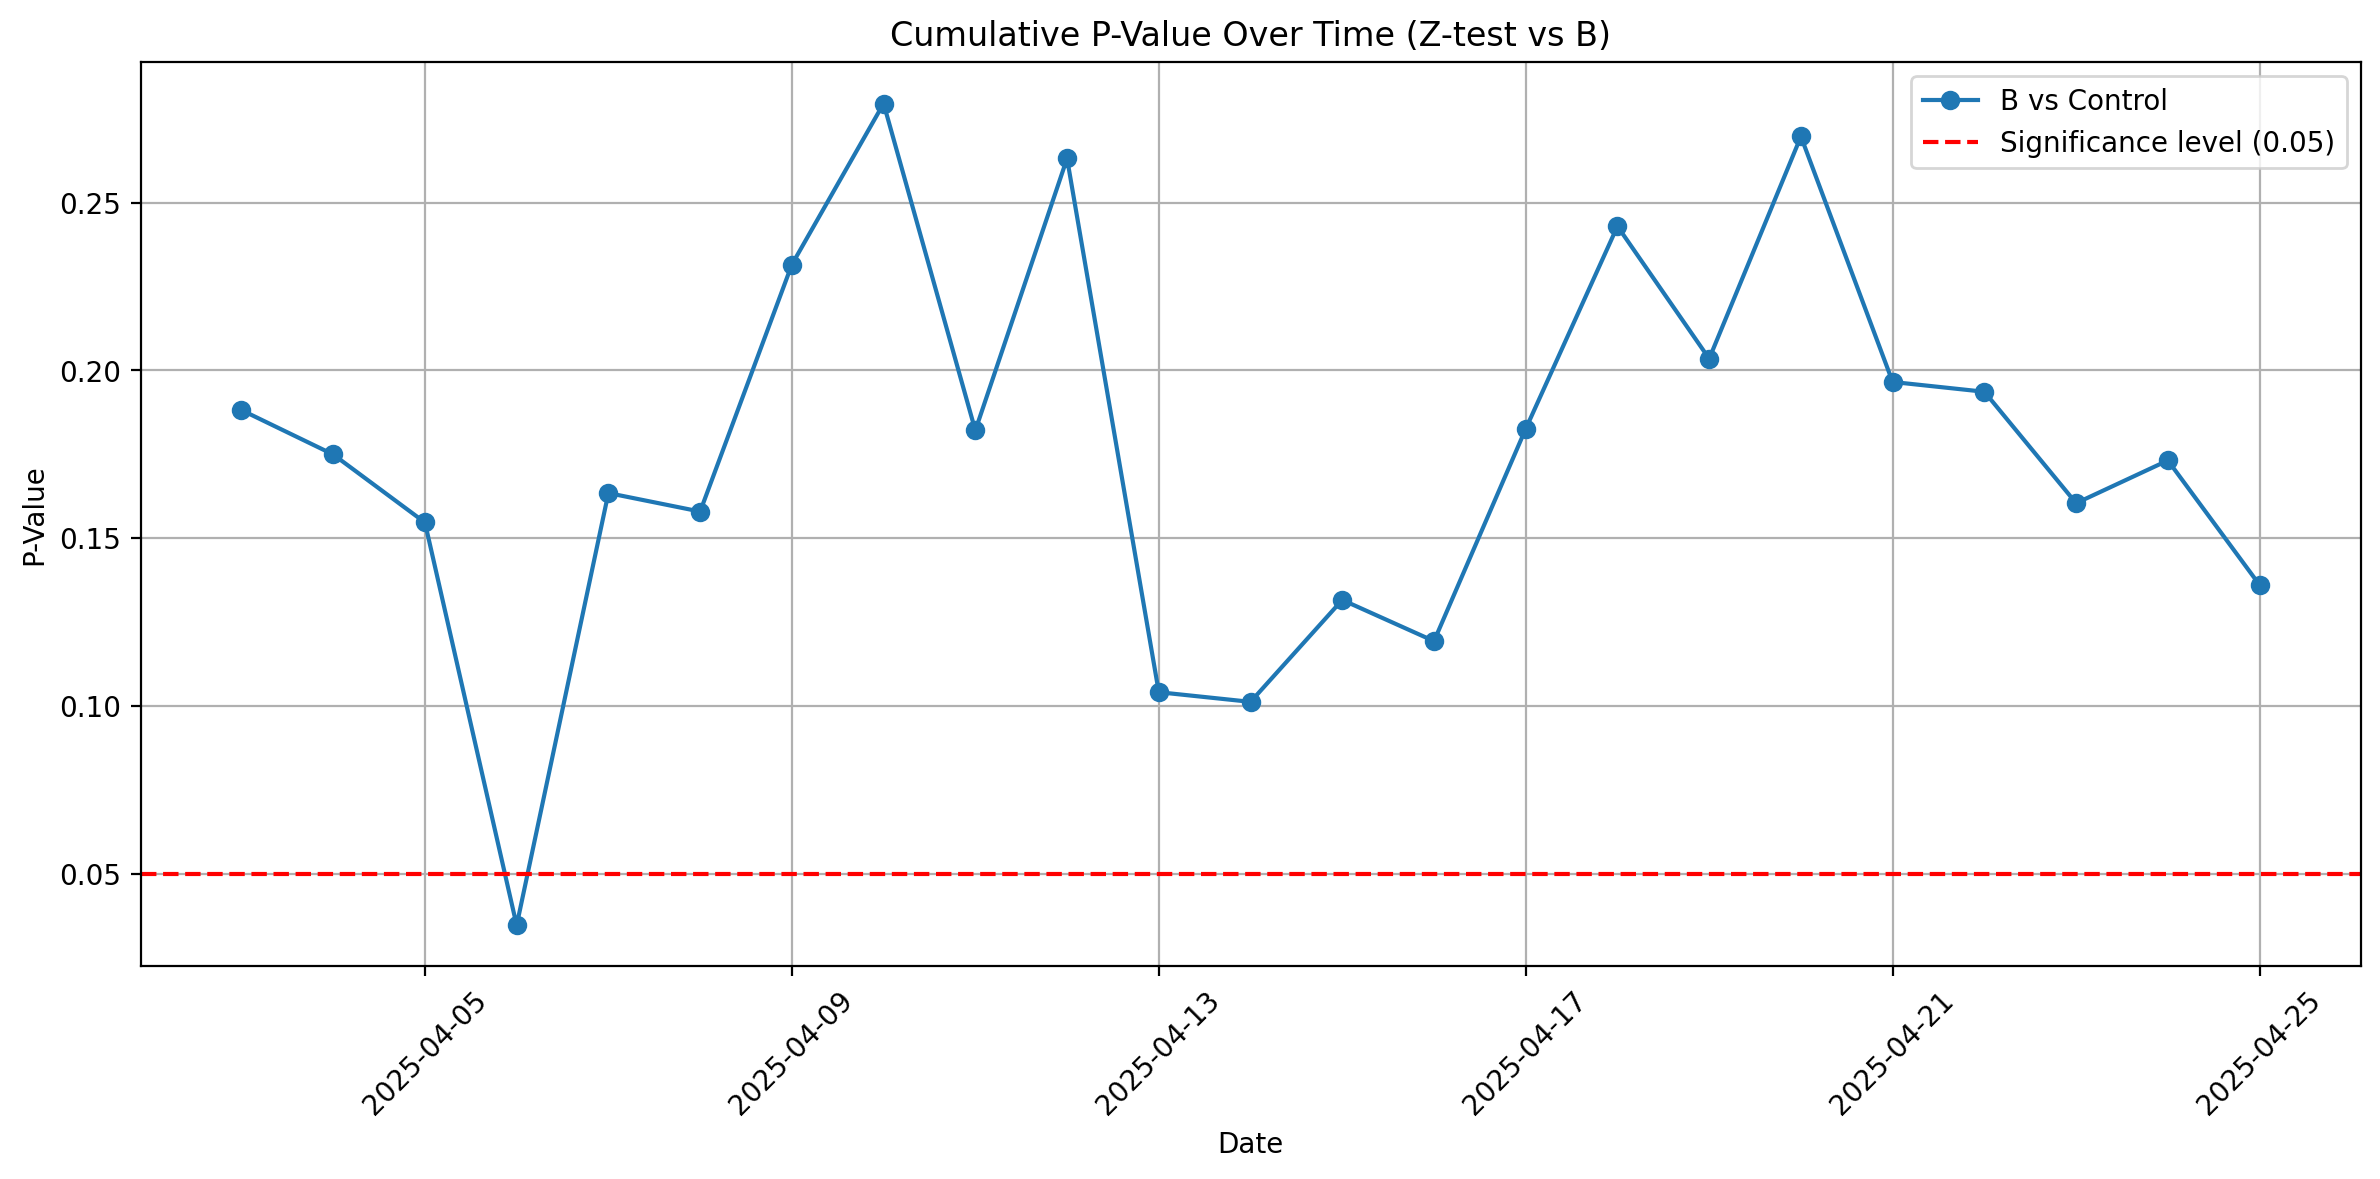

,date,p_value,z_score,group_vs,p1,p2
0,2025-04-03,0.188,1.316,B vs Control,0.775,0.770
1,2025-04-04,0.175,1.356,B vs Control,0.775,0.771
2,2025-04-05,0.155,1.423,B vs Control,0.774,0.771
3,2025-04-06,0.035,2.112,B vs Control,0.776,0.772
4,2025-04-07,0.163,1.394,B vs Control,0.776,0.774
5,2025-04-08,0.158,1.412,B vs Control,0.779,0.776
6,2025-04-09,0.232,1.196,B vs Control,0.780,0.778
7,2025-04-10,0.279,1.081,B vs Control,0.782,0.780
8,2025-04-11,0.182,1.334,B vs Control,0.784,0.782
9,2025-04-12,0.263,1.119,B vs Control,0.787,0.785


In [81]:
cumulative_ztest_vs_B(df_control, group_col='group_name', date_col='created_dt_part', metric_col='approve_flag')

In [12]:
df=read_bq("""
WITH cte AS (SELECT t1.user_id,
                    t1.name,
                    TIMESTAMP_MILLIS(t1.client_time)                        AS utc_time,
                    DATETIME(TIMESTAMP_MILLIS(t1.client_time), t3.timezone) AS local_time,
                    TIMESTAMP_ADD(
                            TIMESTAMP_TRUNC(DATETIME(TIMESTAMP_MILLIS(t1.client_time), t3.timezone), HOUR),
                            INTERVAL
                            CAST(FLOOR(EXTRACT(MINUTE FROM DATETIME(TIMESTAMP_MILLIS(t1.client_time), t3.timezone)) /
                                       10) *
                                 10 AS INT64) MINUTE
                    )                                                       AS timestamp_10_minute_slice_start,
                    TIMESTAMP_ADD(
                            TIMESTAMP_TRUNC(DATETIME(TIMESTAMP_MILLIS(t1.client_time), t3.timezone), HOUR),
                            INTERVAL
                            CAST(FLOOR(EXTRACT(MINUTE FROM DATETIME(TIMESTAMP_MILLIS(t1.client_time), t3.timezone)) /
                                       30) *
                                 30 AS INT64) MINUTE
                    )                                                       AS timestamp_30_minute_slice_start,
                    t1.event_dt_part,
                    t1.city_id,
                    t2.city_name,
                    t1.country_id,
                    t2.country_name,
                    t1.os_name,
                    t1.app_version
             FROM indriver-e6e40.emart.product_event t1
                      JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                           ON
                               t1.city_id = t2.city_id
                      JOIN indriver-e6e40.ods_monolith.tbl_city t3
                           ON
                               t1.city_id = t3.id
             WHERE t1.name = 'city.client.radar.view'
               AND t1.event_dt_part BETWEEN '2025-05-10'
                 AND DATE_ADD(CURRENT_DATE()
                     , INTERVAL -1 DAY)
               AND t1.country_id = 2
               AND t1.city_id = 169)
SELECT timestamp_30_minute_slice_start,
       os_name,
       COUNT(DISTINCT user_id) AS users
FROM cte
WHERE DATE(timestamp_30_minute_slice_start) BETWEEN '2025-05-10'
          AND DATE_ADD(CURRENT_DATE(), INTERVAL -1 DAY)
GROUP BY 1, 2

""")

df.head()

,timestamp_30_minute_slice_start,os_name,users
0,2025-05-19 20:30:00,ios,788
1,2025-05-20 03:30:00,android,129
2,2025-05-19 23:30:00,ios,1021
3,2025-05-20 04:00:00,ios,161
4,2025-05-19 15:00:00,ios,1051


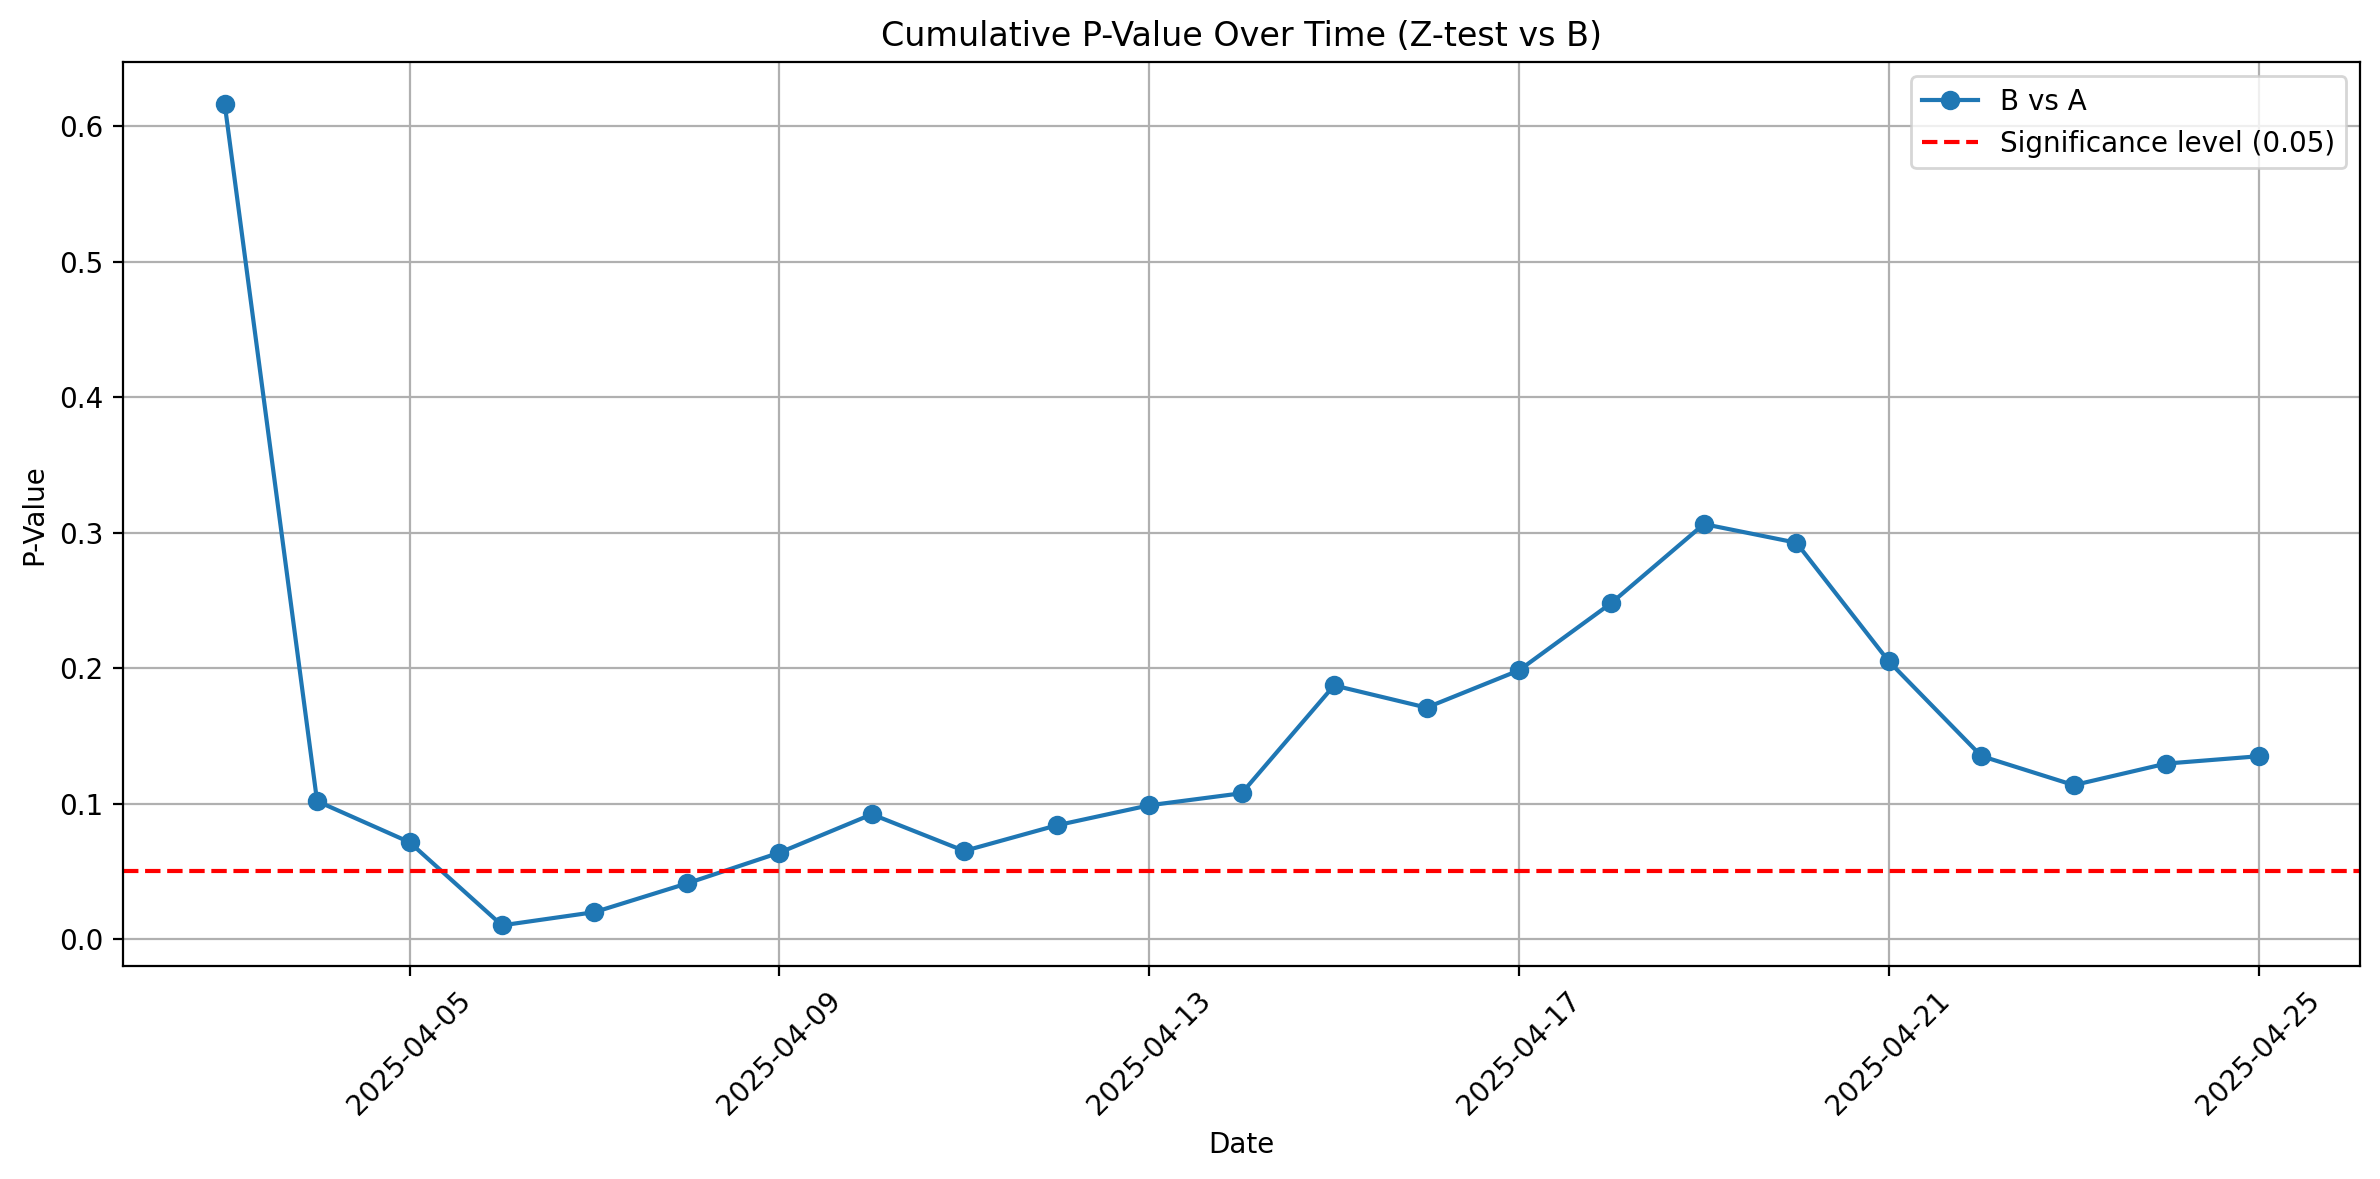

,date,p_value,z_score,group_vs,p1,p2
0,2025-04-03,0.617,0.501,B vs A,0.775,0.773
1,2025-04-04,0.102,1.637,B vs A,0.775,0.770
2,2025-04-05,0.071,1.803,B vs A,0.774,0.770
3,2025-04-06,0.010,2.573,B vs A,0.776,0.771
4,2025-04-07,0.020,2.330,B vs A,0.776,0.772
5,2025-04-08,0.041,2.044,B vs A,0.779,0.775
6,2025-04-09,0.064,1.854,B vs A,0.780,0.777
7,2025-04-10,0.092,1.685,B vs A,0.782,0.779
8,2025-04-11,0.065,1.845,B vs A,0.784,0.781
9,2025-04-12,0.084,1.729,B vs A,0.787,0.784


In [80]:
cumulative_ztest_vs_B(df_5m, group_col='group_name', date_col='created_dt_part', metric_col='approve_flag')

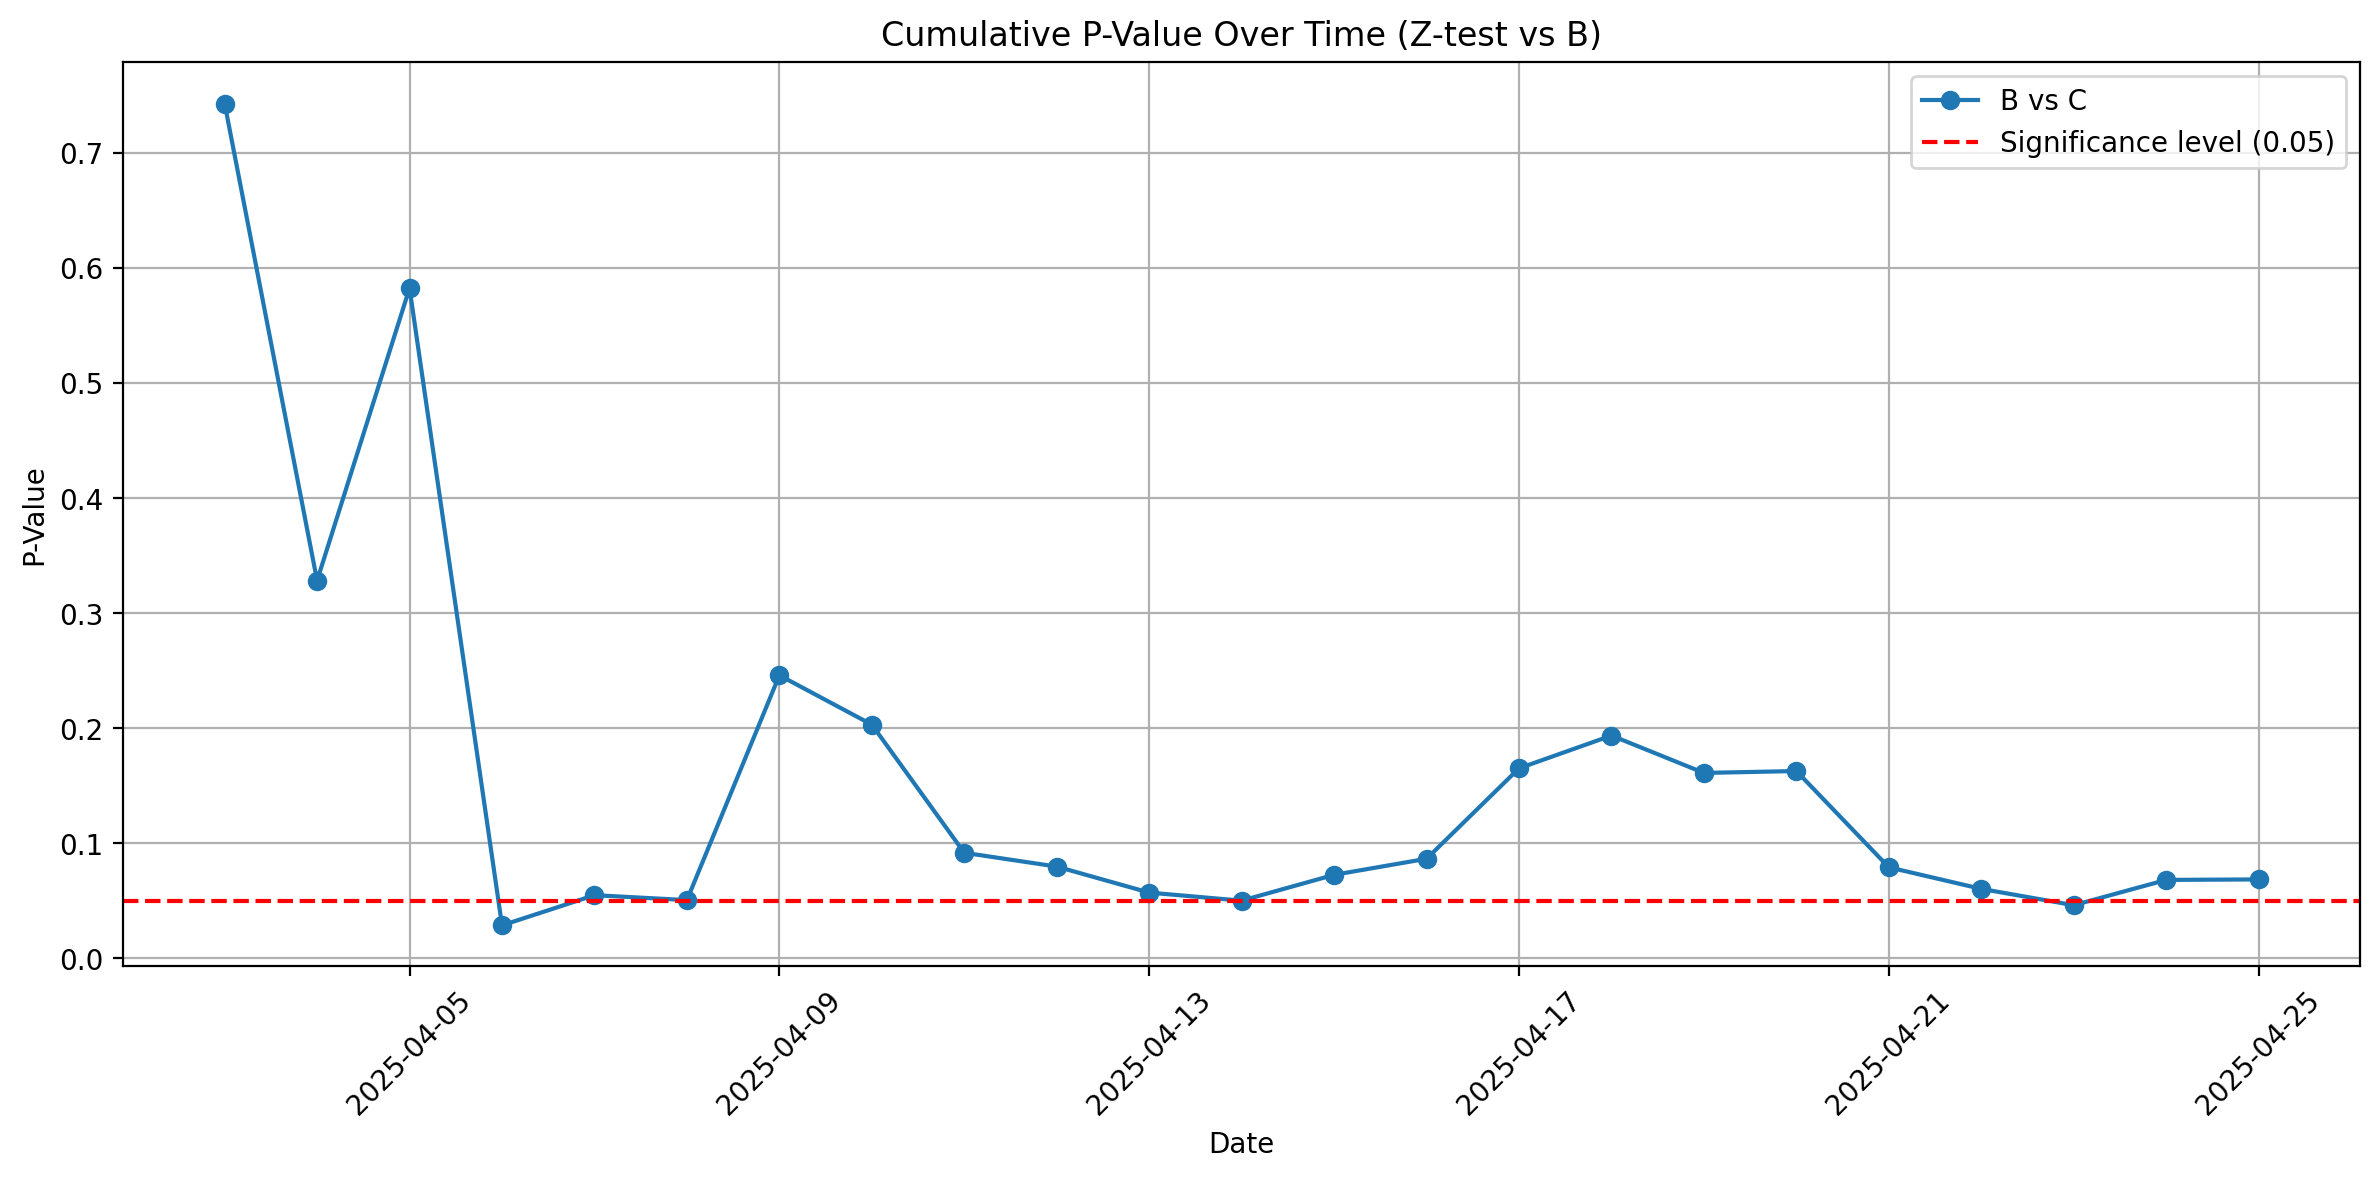

,date,p_value,z_score,group_vs,p1,p2
0,2025-04-03,0.743,0.328,B vs C,0.775,0.773
1,2025-04-04,0.328,0.977,B vs C,0.775,0.772
2,2025-04-05,0.583,0.550,B vs C,0.774,0.773
3,2025-04-06,0.029,2.187,B vs C,0.776,0.772
4,2025-04-07,0.055,1.919,B vs C,0.776,0.773
5,2025-04-08,0.051,1.954,B vs C,0.779,0.775
6,2025-04-09,0.246,1.160,B vs C,0.780,0.778
7,2025-04-10,0.203,1.272,B vs C,0.782,0.780
8,2025-04-11,0.092,1.686,B vs C,0.784,0.782
9,2025-04-12,0.080,1.752,B vs C,0.787,0.784


In [79]:
cumulative_ztest_vs_B(df_6h, group_col='group_name', date_col='created_dt_part', metric_col='approve_flag')

In [65]:
ztest_proportion(df_6h, 'approve_flag', 'group_name_digit')

,metric_name,group0_sample_size,group1_sample_size,group0,group1,statistic,pvalue,mean0,mean1,diff_mean,diff_mean_%,lb,ub,lb_%,ub_%
0,approve_flag,272610,273221,0,1,-1.821,0.069,0.803,0.805,0.002,0.243,-0.000,0.004,-0.019,0.505
